# **RANDOM FORESTS**

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:


df = pd.read_excel('/content/sample_data/Kemondo_Sales_final.xlsx')



df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)


df.head()

,Date,Sales
0,2021-08-06,191840.0
1,2021-08-07,343280.0
2,2021-08-09,311720.0
3,2021-08-10,358750.0
4,2021-08-11,173410.0


Weekly

In [3]:
# Aggregating to weekly (sum of daily sales)
df_weekly = df.set_index('Date').resample('W').sum().reset_index()

# Aggregating to monthly (sum of daily sales)
df_monthly = df.set_index('Date').resample('M').sum().reset_index()

print(f"Daily observations: {len(df)}")
print(f"Weekly observations: {len(df_weekly)}")
print(f"Monthly observations: {len(df_monthly)}")


Daily observations: 1319
Weekly observations: 224
Monthly observations: 52


/tmp/ipython-input-4163811515.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.set_index('Date').resample('M').sum().reset_index()


In [4]:
def create_features_weekly(df):
    """
    Feature engineering for weekly aggregated data
    """
    df = df.copy()

    # Temporal features
    df['weekofyear'] = df['Date'].dt.isocalendar().week
    df['month'] = df['Date'].dt.month
    df['quarter'] = df['Date'].dt.quarter
    df['year'] = df['Date'].dt.year

    # Cyclical encoding for annual seasonality
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # Peak planting season indicator (Aug-Oct)
    df['peak_season'] = ((df['month'] >= 8) & (df['month'] <= 10)).astype(int)

    # Lag features (in weeks)
    df['sales_lag_1'] = df['Sales'].shift(1)   # 1 week ago
    df['sales_lag_2'] = df['Sales'].shift(2)   # 2 weeks ago
    df['sales_lag_4'] = df['Sales'].shift(4)   # ~1 month ago
    df['sales_lag_12'] = df['Sales'].shift(12) # ~3 months ago

    # Rolling statistics (4-week and 12-week windows)
    df['sales_rolling_mean_4'] = df['Sales'].rolling(window=4, min_periods=1).mean()
    df['sales_rolling_std_4'] = df['Sales'].rolling(window=4, min_periods=1).std()
    df['sales_rolling_mean_12'] = df['Sales'].rolling(window=12, min_periods=1).mean()

    # Trend indicator
    df['time_index'] = np.arange(len(df))

    return df

# Apply feature engineering
df_weekly = create_features_weekly(df_weekly)



Monthly

In [5]:
# Aggregate daily data to monthly (sum of daily sales)
df_monthly = df.set_index('Date').resample('M').sum().reset_index()

print(f"Daily observations: {len(df)}")
print(f"Monthly observations: {len(df_monthly)}")


Daily observations: 1319
Monthly observations: 52


/tmp/ipython-input-4125288983.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.set_index('Date').resample('M').sum().reset_index()


In [6]:
def create_features_monthly(df):
    """
    Feature engineering for monthly aggregated data
    """
    df = df.copy()

    # Temporal features
    df['month'] = df['Date'].dt.month
    df['quarter'] = df['Date'].dt.quarter
    df['year'] = df['Date'].dt.year

    # Cyclical encoding for seasonality
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # Peak planting season indicator (Aug-Oct)
    df['peak_season'] = ((df['month'] >= 8) & (df['month'] <= 10)).astype(int)

    # Lag features based on monthly ACF/PACF
    df['sales_lag_1'] = df['Sales'].shift(1)   # Previous month
    df['sales_lag_12'] = df['Sales'].shift(12) # Annual seasonality

    # Rolling statistics (3-month and 6-month windows)
    df['sales_rolling_mean_3'] = df['Sales'].rolling(window=3, min_periods=1).mean()
    df['sales_rolling_std_3'] = df['Sales'].rolling(window=3, min_periods=1).std()
    df['sales_rolling_mean_6'] = df['Sales'].rolling(window=6, min_periods=1).mean()

    # Trend indicator
    df['time_index'] = np.arange(len(df))

    return df

# Apply feature engineering
df_monthly = create_features_monthly(df_monthly)




Train Split

In [7]:
# Time-based split: 80% training, 20% testing
split_date = '2025-01-01'

# For weekly data
train_weekly = df_weekly[df_weekly['Date'] < split_date].copy()
test_weekly = df_weekly[df_weekly['Date'] >= split_date].copy()

# For monthly data
train_monthly = df_monthly[df_monthly['Date'] < split_date].copy()
test_monthly = df_monthly[df_monthly['Date'] >= split_date].copy()

# Remove NaN from lag features
train_weekly = train_weekly.dropna()
test_weekly = test_weekly.dropna()
train_monthly = train_monthly.dropna()
test_monthly = test_monthly.dropna()

print(f"\nWeekly - Train: {len(train_weekly)}, Test: {len(test_weekly)}")
print(f"Monthly - Train: {len(train_monthly)}, Test: {len(test_monthly)}")




Weekly - Train: 166, Test: 46
Monthly - Train: 29, Test: 11


Weekly

In [15]:
# Defining features
feature_cols_weekly = ['weekofyear', 'month', 'quarter', 'month_sin', 'month_cos',
                       'peak_season', 'time_index',
                       'sales_lag_1', 'sales_lag_2', 'sales_lag_4', 'sales_lag_12',
                       'sales_rolling_mean_4', 'sales_rolling_std_4', 'sales_rolling_mean_12']

# Preparing data
X_train = train_weekly[feature_cols_weekly]
y_train = train_weekly['Sales']
X_test = test_weekly[feature_cols_weekly]
y_test = test_weekly['Sales']

rf_model_weekly = RandomForestRegressor(
    n_estimators=400,
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=0.8,
    bootstrap=False,
    random_state=42,
    n_jobs=-1
)


rf_model_weekly.fit(X_train, y_train)

# Predictions
y_pred_weekly = rf_model_weekly.predict(X_test)



In [16]:
# Weekly metrics
mae_w = mean_absolute_error(y_test, y_pred_weekly)
rmse_w = np.sqrt(mean_squared_error(y_test, y_pred_weekly))
r2_w = r2_score(y_test, y_pred_weekly)
mape_w = mean_absolute_percentage_error(y_test, y_pred_weekly) * 100

print("=== Random Forest Performance (Weekly) ===")
print(f"MAE: {mae_w:.4f}")
print(f"RMSE: {rmse_w:.4f}")
print(f"R²: {r2_w:.4f}")
print(f"MAPE: {mape_w:.2f}%")


=== Random Forest Performance (Weekly) ===
MAE: 974917.6416
RMSE: 1388935.1698
R²: 0.3185
MAPE: 40.62%


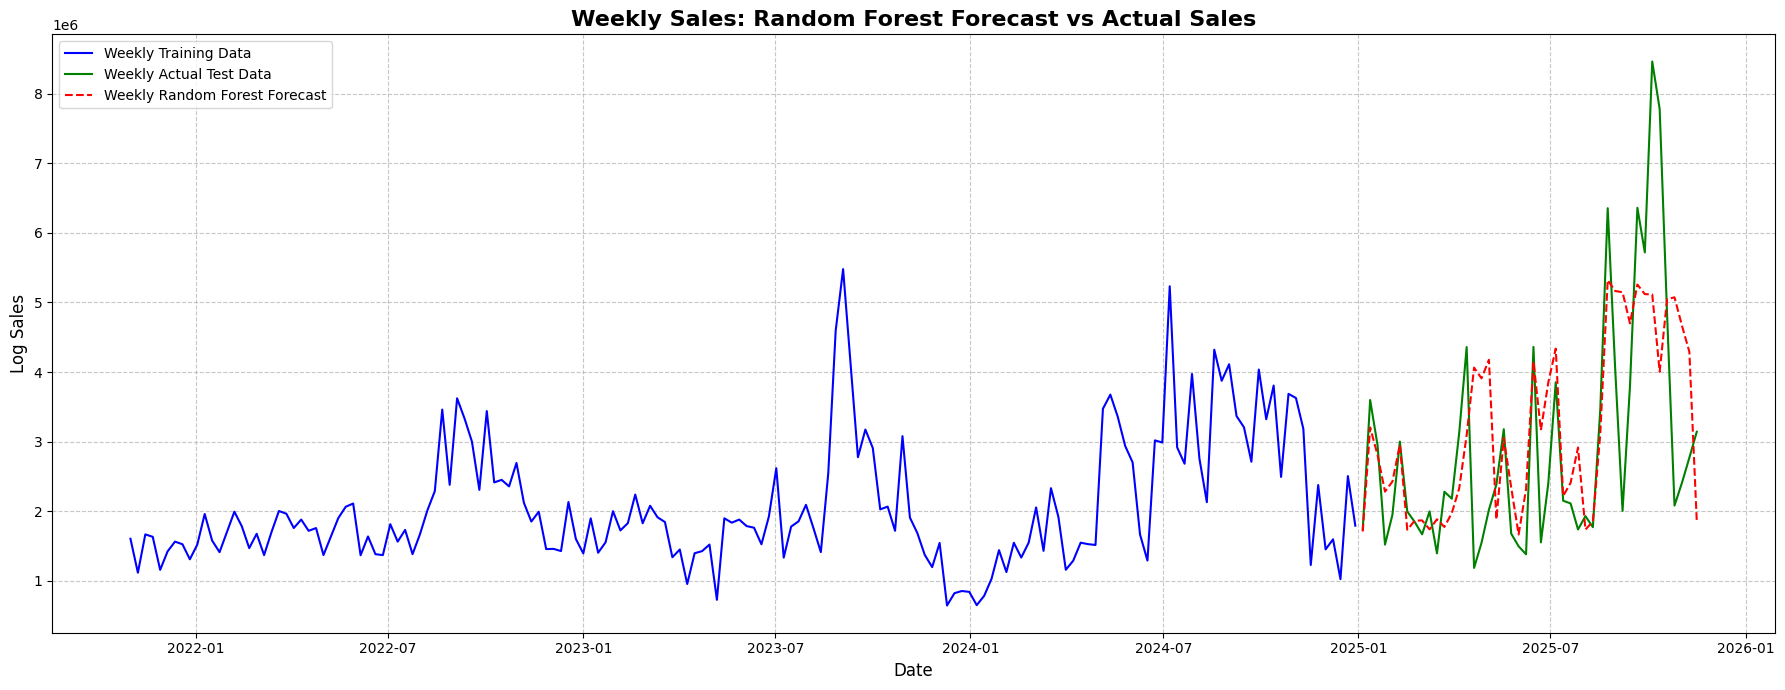

In [17]:
# Combining train and test data for plotting
train_weekly_plot = train_weekly[['Date', 'Sales']].copy()
train_weekly_plot['Type'] = 'Training Data'

test_weekly_plot = test_weekly[['Date', 'Sales']].copy()
test_weekly_plot['Actual'] = test_weekly_plot['Sales']
test_weekly_plot['RF_Forecast'] = y_pred_weekly

# Plotting Weekly Random Forest Forecast
plt.figure(figsize=(18, 7))
sns.lineplot(x='Date', y='Sales', data=train_weekly_plot, label='Weekly Training Data', color='blue')
sns.lineplot(x='Date', y='Actual', data=test_weekly_plot, label='Weekly Actual Test Data', color='green')
sns.lineplot(x='Date', y='RF_Forecast', data=test_weekly_plot, label='Weekly Random Forest Forecast', color='red', linestyle='--')
plt.title('Weekly Sales: Random Forest Forecast vs Actual Sales', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Log Sales', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()




Monthly

In [11]:
# Time-based split: 80% training, 20% testing
split_date = '2024-06-01'

# Splitting monthly data
train_monthly = df_monthly[df_monthly['Date'] < split_date].copy()
test_monthly = df_monthly[df_monthly['Date'] >= split_date].copy()

# Removing NaN from lag features
train_monthly = train_monthly.dropna()
test_monthly = test_monthly.dropna()

print(f"Monthly - Train: {len(train_monthly)}, Test: {len(test_monthly)}")


Monthly - Train: 22, Test: 18


# **Parameters Hpyertuning**

In [13]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error


def tune_random_forest_ts(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    feature_cols: list,
    target_col: str = "Sales",
    n_iter: int = 30,
    n_splits: int = 3,
    random_state: int = 42,
    n_jobs: int = -1,
):
    """
    Time-series-aware tuning for RandomForest using TimeSeriesSplit + RandomizedSearchCV.
    Returns best model, best params, CV results (DataFrame), and test metrics + predictions.
    """

    # ---- Preparing X/y
    X_train = train_df[feature_cols].copy()
    y_train = train_df[target_col].copy()
    X_test  = test_df[feature_cols].copy()
    y_test  = test_df[target_col].copy()


    if len(X_train) < (n_splits + 1) * 5:
        print("Warning: Training set is small relative to CV splits. Consider reducing n_splits or n_iter.")

    # ---- Base model
    rf = RandomForestRegressor(
        random_state=random_state,
        n_jobs=n_jobs
    )

    # ---- Parameter search space
    param_dist = {
        "n_estimators": [200, 400, 800, 1200],
        "max_depth": [None, 5, 10, 15, 20, 30],
        "min_samples_split": [2, 5, 10, 20],
        "min_samples_leaf": [1, 2, 4, 8],
        "max_features": ["sqrt", "log2", 0.5, 0.8, 1.0],
        "bootstrap": [True, False],
    }

    # ---- Time-series CV
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # ---- Randomized Search
    search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring="neg_mean_absolute_error",
        cv=tscv,
        random_state=random_state,
        n_jobs=n_jobs,
        verbose=1,
        refit=True,
    )

    search.fit(X_train, y_train)

    best_model = search.best_estimator_
    best_params = search.best_params_

    # ---- Predict on test
    y_pred = best_model.predict(X_test)

    # ---- Metrics
    test_mae = mean_absolute_error(y_test, y_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # ---- CV results table (sorted best-to-worst by MAE)
    cv_results = pd.DataFrame(search.cv_results_)
    cv_results["mean_MAE"] = -cv_results["mean_test_score"]  # convert back to +MAE
    cv_results = cv_results.sort_values("mean_MAE").reset_index(drop=True)

    return {
        "best_model": best_model,
        "best_params": best_params,
        "cv_results": cv_results,
        "test_mae": test_mae,
        "test_rmse": test_rmse,
        "y_pred": y_pred,
    }



# MONTHLY

monthly_tuned = tune_random_forest_ts(
    train_df=train_monthly,
    test_df=test_monthly,
    feature_cols= feature_cols_monthly,
    target_col="Sales",
    n_iter=30,
    n_splits=3
)

print("MONTHLY best params:", monthly_tuned["best_params"])
print(f"MONTHLY Test MAE:  {monthly_tuned['test_mae']:.2f}")
print(f"MONTHLY Test RMSE: {monthly_tuned['test_rmse']:.2f}")




# WEEKLY

weekly_tuned = tune_random_forest_ts(
    train_df=train_weekly,
    test_df=test_weekly,
    feature_cols=feature_cols_weekly,
    target_col="Sales",
    n_iter=30,
    n_splits=3
)

print("WEEKLY best params:", weekly_tuned["best_params"])
print(f"WEEKLY Test MAE:  {weekly_tuned['test_mae']:.2f}")
print(f"WEEKLY Test RMSE: {weekly_tuned['test_rmse']:.2f}")

test_weekly_rf = test_weekly.copy()
test_weekly_rf["RF_Forecast"] = weekly_tuned["y_pred"]




Fitting 3 folds for each of 30 candidates, totalling 90 fits
MONTHLY best params: {'n_estimators': 1200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.5, 'max_depth': 5, 'bootstrap': False}
MONTHLY Test MAE:  2807290.27
MONTHLY Test RMSE: 4064481.00
Fitting 3 folds for each of 30 candidates, totalling 90 fits
WEEKLY best params: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.8, 'max_depth': 5, 'bootstrap': False}
WEEKLY Test MAE:  974917.64
WEEKLY Test RMSE: 1388935.17


,mean_MAE,params
0,2.086545e+06,"{'n_estimators': 1200, 'min_samples_split': 5,..."
1,2.144488e+06,"{'n_estimators': 200, 'min_samples_split': 5, ..."
2,2.159321e+06,"{'n_estimators': 1200, 'min_samples_split': 5,..."
3,2.159321e+06,"{'n_estimators': 1200, 'min_samples_split': 5,..."
4,2.221034e+06,"{'n_estimators': 800, 'min_samples_split': 2, ..."
5,2.230077e+06,"{'n_estimators': 800, 'min_samples_split': 2, ..."
6,2.238305e+06,"{'n_estimators': 400, 'min_samples_split': 2, ..."
7,2.283949e+06,"{'n_estimators': 400, 'min_samples_split': 5, ..."
8,2.291397e+06,"{'n_estimators': 800, 'min_samples_split': 5, ..."
9,2.297761e+06,"{'n_estimators': 1200, 'min_samples_split': 5,..."


,mean_MAE,params
0,465395.935542,"{'n_estimators': 400, 'min_samples_split': 2, ..."
1,478986.570953,"{'n_estimators': 400, 'min_samples_split': 20,..."
2,482510.260265,"{'n_estimators': 800, 'min_samples_split': 2, ..."
3,485883.994362,"{'n_estimators': 800, 'min_samples_split': 5, ..."
4,486966.258246,"{'n_estimators': 1200, 'min_samples_split': 5,..."
5,488815.923071,"{'n_estimators': 800, 'min_samples_split': 10,..."
6,490973.993165,"{'n_estimators': 1200, 'min_samples_split': 10..."
7,491631.821674,"{'n_estimators': 400, 'min_samples_split': 2, ..."
8,492534.648019,"{'n_estimators': 800, 'min_samples_split': 2, ..."
9,495361.099363,"{'n_estimators': 800, 'min_samples_split': 10,..."


In [18]:
# Defining features for monthly model
feature_cols_monthly = ['month', 'quarter', 'month_sin', 'month_cos',
                        'peak_season', 'time_index',
                        'sales_lag_1', 'sales_lag_12',
                        'sales_rolling_mean_3', 'sales_rolling_std_3', 'sales_rolling_mean_6']

# Preparing data
X_train_m = train_monthly[feature_cols_monthly]
y_train_m = train_monthly['Sales']
X_test_m = test_monthly[feature_cols_monthly]
y_test_m = test_monthly['Sales']

# Training Random Forest
rf_model_monthly = RandomForestRegressor(
    n_estimators=1200,
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features=0.5,
    bootstrap=False,
    random_state=42,
    n_jobs=-1
)

rf_model_monthly.fit(X_train_m, y_train_m)

# Predictions
y_pred_monthly = rf_model_monthly.predict(X_test_m)


In [19]:
# Calculate metrics
mae_m = mean_absolute_error(y_test_m, y_pred_monthly)
rmse_m = np.sqrt(mean_squared_error(y_test_m, y_pred_monthly))
r2_m = r2_score(y_test_m, y_pred_monthly)
mape_m = mean_absolute_percentage_error(y_test_m, y_pred_monthly) * 100

print("=== Random Forest Performance (Monthly) ===")
print(f"MAE: {mae_m:.4f}")
print(f"RMSE: {rmse_m:.4f}")
print(f"R²: {r2_m:.4f}")
print(f"MAPE: {mape_m:.2f}%")


=== Random Forest Performance (Monthly) ===
MAE: 2807290.2717
RMSE: 4064481.0048
R²: 0.1404
MAPE: 19.49%


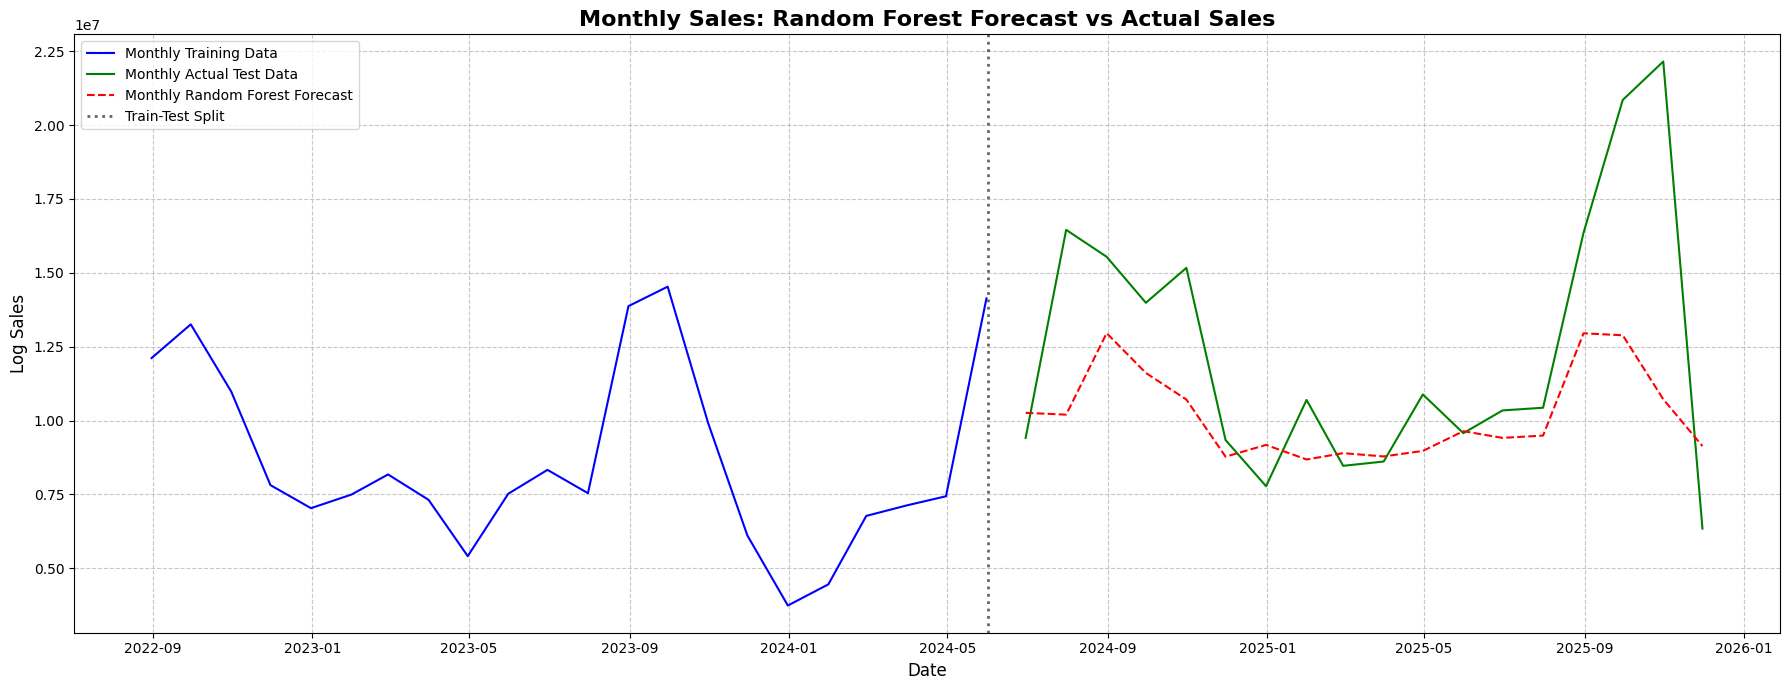

In [20]:
# Prepare data for plotting
train_monthly_plot = train_monthly[['Date', 'Sales']].copy()
test_monthly_plot = test_monthly[['Date', 'Sales']].copy()
test_monthly_plot['Actual'] = test_monthly_plot['Sales']
test_monthly_plot['RF_Forecast'] = y_pred_monthly

# Plotting Monthly Random Forest Forecast
plt.figure(figsize=(18, 7))
sns.lineplot(x='Date', y='Sales', data=train_monthly_plot, label='Monthly Training Data', color='blue')
sns.lineplot(x='Date', y='Actual', data=test_monthly_plot, label='Monthly Actual Test Data', color='green')
sns.lineplot(x='Date', y='RF_Forecast', data=test_monthly_plot, label='Monthly Random Forest Forecast', color='red', linestyle='--')
plt.axvline(x=pd.to_datetime(split_date), color='black', linestyle=':', linewidth=2, label='Train-Test Split', alpha=0.6)
plt.title('Monthly Sales: Random Forest Forecast vs Actual Sales', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Log Sales', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
